In [1]:
%run nbloader.py
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import pylab as plt
import root_numpy
import pandas as pd
import math
from sklearn.cluster import DBSCAN

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
%load_ext Cython


BRICK_X = 124000
BRICK_Y = 99000
BRICK_Z = 75000
SAFE_M = 10000


In [2]:
from read_opera_bg import plot_bg;

importing notebook from read_opera_bg.ipynb
bg: 2767 tracks
len(slopes): 2767


In [3]:
from sklearn.svm import SVC
import pandas as pd

from read_opera_bg import load_bg;
from read_opera_mc import load_mc;
pbg = load_bg(step=1);
pmc = load_mc(step=1);

importing notebook from read_opera_mc.ipynb
numtracks reduction by cuts:  [188, 186, 109, 50, 19, 19]
bg: 27322110 tracks
numtracks reduction by cuts:  [18724, 18678, 11058, 5389, 2799, 2684]


In [81]:
def centralize_shower(shower):
    x_diff = shower['ele_x'] - 50000
    y_diff = shower['ele_y'] - 40000
    shower.loc['BT_X'] = shower.loc['BT_X'] - x_diff
    shower.loc['BT_Y'] = shower.loc['BT_Y'] - y_diff
    return shower


def generate_training_sample(pmc, pbg):
    z_coordinates = list(set(pbg['s.eZ']))
    z_coordinates.sort()
    def f(x): return x > 60000
    z_coordinates = filter(f, z_coordinates)
    
    data_to_clear = pbg[pbg['s.eZ'].isin(z_coordinates)]
    data_to_clear = data_to_clear.apply(np.random.permutation)
    data_to_clear['signal'] = 0
    data_to_clear = data_to_clear[:500000]
    
    
    parents = list()
    sons = list()

    for i in range(20, 1000):
        my_shower = pmc.iloc[i]
        shower_frame = pd.DataFrame([
            my_shower['BT_X'],
            my_shower['BT_Y'],
            my_shower['BT_Z'] - my_shower['BT_Z'] % 1293,
            my_shower['BT_SX'],
            my_shower['BT_SY']],
            index=['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY']).T
        shower_frame['signal'] = 1
        shower_frame['s.eChi2'] = 0
        shower_frame = shower_frame[shower_frame['s.eZ'].isin(z_coordinates)]

        numpy_frame = np.asarray(shower_frame)

        for i in range(len(z_coordinates)):
            for track in numpy_frame[numpy_frame[:, 2] == z_coordinates[i] ,:]:
                next_layer = numpy_frame[numpy_frame[:, 2] == z_coordinates[i + 1] ,:]
                if (len(next_layer) != 0):
                    IP = compute_metric_distance(track, next_layer, classifier = False, IP_mode=True)
                    if (IP.min() < 0.001):
                        parents.append(track)
                        sons.append(next_layer[IP.argmin(), :])

    sons = np.asarray(sons)
    parents = np.asarray(parents)

    noise_sons = list()
    noise_parents = list()
    for i in range(40):
        number = np.random.randint(len(data_to_clear))
        track = data_to_clear.iloc[number, :]
        track = np.asarray(track)
        layer = data_to_clear[data_to_clear['s.eZ'] == track[2] + 1293]
        next_layer = np.asarray(layer)
        bool_index = (abs(next_layer[:, 0] - track[0]) < 10000) & (abs(next_layer[:, 1] - track[1]) < 10000)
        next_layer = next_layer[bool_index]
        noise_sons.extend([track] * len(next_layer))

        noise_parents.append(next_layer)

    noise_sons = np.asarray(noise_sons)
    noise_parents = np.concatenate(noise_parents)
    
    signal_part = compute_features(sons, parents)
    noise_part = compute_features(noise_sons, noise_parents)
    
    signal_part = np.insert(signal_part, len(signal_part[0, :]),1,axis = 1)
    noise_part = np.insert(noise_part, len(noise_part[0, :]), 0,axis = 1)
    
    df = np.concatenate([signal_part, noise_part], axis = 0)
    return df

def prepare_for_testing(pmc, data_to_clear, i = 15):
    my_shower = pmc.iloc[15]
    my_shower = centralize_shower(my_shower.copy())
    shower_frame = pd.DataFrame([
                    my_shower['BT_X'],
                    my_shower['BT_Y'],
                    my_shower['BT_Z'] - my_shower['BT_Z'] % 1293,
                    my_shower['BT_SX'],
                    my_shower['BT_SY']],
                    index=['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY']).T
    shower_frame['signal'] = 1
    shower_frame['s.eChi2'] = 0

    shower_frame = shower_frame[shower_frame['s.eZ'].isin(z_coordinates)]
    index=['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY', 'signal']
    testing_data = pd.concat([shower_frame, data_to_clear])
    testing_data = testing_data[index]
    testing_data['number_of_ancestors'] = 0
    testing_data['parent_index'] = -1
    columns = testing_data.columns
    testing_data_1 = np.asarray(testing_data)
    
    return testing_data_1

def test_estimator(clf, test_data, thres = 0.9, number_of_iterations = 1):
    columns = ['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY', 'signal', 'number_of_ancestors', 'parent_index']
    cleared_data = shower_finder(test_data, number_of_iterations = 1, classifier = clf, box_size = 1000, threshold = thres)
    cleared_data = pd.DataFrame(cleared_data,columns = columns)
    
    return cleared_data

def precision_recall(cleared_data, original_shower_size):
    tp = np.sum(cleared_data.signal == 1) + 0.
    fp = np.sum(cleared_data.signal == 0)
    precision = tp / (tp + fp)
    recall = tp / original_shower_size
    return [precision, recall]

In [5]:
%%cython
import numpy as np
dZ = 205


def compute_features(sons, parents):
    distance = np.sqrt(np.sum((parents - sons)[:, 0:3]**2, axis = 1))
    tan_angle = np.tan(np.arccos(1/(np.sqrt(np.sum((sons - parents)[:, 3:5]**2, axis = 1) + 1))))

    angle_z_son = tan_angle
    if (len(sons.shape) == 1):
        track_begin = sons[0:3]
        track_end = np.copy(track_begin)
        track_end[0] += dZ * sons[3]
        track_end[1] += dZ * sons[4]
        track_end[2] += dZ
        track_diff = track_end - track_begin
        angle_z_son = (dZ ** 2)/(np.linalg.norm(track_diff) * dZ)
        angle_z_son = np.asarray([angle_z_son]*len(parents))
    else:
        track_begin = sons[:, 0:3]

        track_end = np.copy(track_begin)
        track_end[:, 0] += dZ * sons[:, 3]
        track_end[:, 1] += dZ * sons[:, 4]
        track_end[:, 2] += dZ
        track_diff = track_end - track_begin
        angle_z_son = (dZ ** 2)/(np.linalg.norm(track_diff, axis = 1) * dZ)
    
    
    track_diff_par = np.transpose(np.asarray([dZ * parents[:, 3], dZ * parents[:, 4]]))
    track_diff_par = np.insert(track_diff_par, 2, dZ, axis = 1)
    
    
    IP_1 = np.linalg.norm(np.cross(parents[:, 0:3] - track_end, parents[:, 0:3] - track_begin), axis = 1)/np.linalg.norm(track_diff)
    IP_2 = np.linalg.norm(np.cross(track_end - parents[:, 0:3], track_end - parents[:, 0:3] - track_diff_par), axis = 1)/np.linalg.norm(track_diff_par)

    angle_z_parents = (dZ ** 2)/(np.linalg.norm(track_diff_par, axis = 1) * dZ)
    return np.transpose(np.asarray([distance/dZ, tan_angle, IP_1/dZ, IP_2/dZ ,angle_z_son, angle_z_parents]))


def compute_metric_distance(track, next_layer, classifier, IP_mode = False):
    if (len(next_layer) == 0):
        return np.asarray([0])
    
    X = compute_features(track, next_layer)
    if IP_mode == True:
        return (X[:, 2]/30)**2

    return classifier.predict_proba(X)[:, 1]

def find_similar(track, next_layer, classifier, threshold, box_size):
    
    track = np.array(track, dtype = float)
    indexes = np.arange(len(next_layer))
    
    bool_index = (abs(next_layer[:, 0] - track[0]) < box_size) & (abs(next_layer[:, 1] - track[1]) < box_size)
    next_layer = next_layer[bool_index]
    indexes = indexes[bool_index]
    
    dist = compute_metric_distance(track, next_layer, classifier)
    result = dist > threshold
    return indexes[result]




def clear_layer(to_clear, to_compare, classifier, threshold, box_size):
    if (len(to_clear) == 0):
        return to_clear
    final_result = np.ndarray((len(to_clear,)),dtype=np.object)
    for i in xrange(len(to_clear)):
        result = find_similar(to_clear[i], to_compare, classifier, threshold, box_size)
        final_result[i] = result
                            
    f = np.vectorize(len)
    bool_index = f(final_result)
    index = bool_index > 0
    
    to_clear = to_clear[index, :]
    if len(to_clear) == 0:
        return to_clear
    result = np.unique(np.hstack(final_result[index]))
    
    to_compare = to_compare[result]

    
    return np.concatenate([to_clear, to_compare])

def shower_finder(data, classifier, number_of_iterations = 1, threshold = 0.98, box_size = 3000):
    layers = list(set(data[:, 2]))
    layers.sort()
    for n in range(number_of_iterations):
        for i in range(len(layers) - 1):
            cleared_data = clear_layer(data[data[:, 2] == layers[i]], data[data[:, 2] == layers[i+1]], classifier, threshold, box_size)
            data = data[(data[:, 2] != layers[i]) & (data[:, 2] != layers[i+1])]
            data = np.concatenate([data, cleared_data])
    return data



In [12]:
np.random.seed(42)
df = generate_training_sample(pmc, pbg)
np.random.shuffle(df)

In [13]:
svm = SVC(C = 1, probability = True)
svm.fit(df[:20000, :6], df[:20000, 6])

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
#from sklearn.externals import joblib
#joblib.dump(svm, 'svm/svm_5_5.pkl');

In [9]:
z_coordinates = list(set(pbg['s.eZ']))
z_coordinates.sort()
def f(x): return x > 60000
z_coordinates = filter(f, z_coordinates)

data_to_clear = pbg[pbg['s.eZ'].isin(z_coordinates)]
data_to_clear = data_to_clear.apply(np.random.permutation)
data_to_clear['signal'] = 0
data_to_clear = data_to_clear[500000:600000]

# Precision / Recall graph

In [82]:
%%time
precision = []
recall = []
for thres in np.linspace(0.7, 0.99, num=10):
    test_data = prepare_for_testing(pmc, data_to_clear, i = 15)
    cleared_data = test_estimator(svm, test_data, thres=thres)
    point = precision_recall(cleared_data, sum(test_data[:, 5] == 1))
    precision.append(point[0])
    recall.append(point[1])


/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:103: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1


CPU times: user 1min 16s, sys: 810 ms, total: 1min 17s
Wall time: 1min 18s


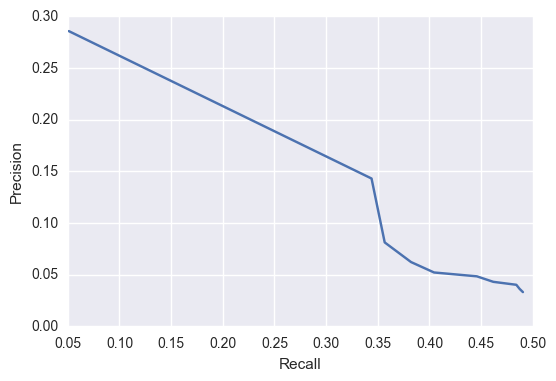

In [84]:
%matplotlib inline
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show();

In [88]:
%matplotlib osx

In [89]:
plot_bg(cleared_data)

len(slopes): 56


Сформируем последовательности и попробуем применить вероятностные модели на графах.

In [52]:
data_to_clear = pbg[pbg['s.eZ'].isin(z_coordinates)]
data_to_clear = data_to_clear.apply(np.random.permutation)
data_to_clear['signal'] = 0
data_to_clear = data_to_clear[500000:1000000]

In [54]:
test_data = prepare_for_testing(pmc, data_to_clear, i = 15)
cleared_data = test_estimator(svm, test_data, thres=0.98)
print "Original shower size: " + str(len(shower_frame))
print "Cleared shower size: " + str(sum(cleared_data.signal == 1))
print "Uncleared noise: " + str(sum(cleared_data.signal == 0))

Original shower size: 314
Cleared shower size: 80
Uncleared noise: 16451


In [109]:
plot_bg(cleared_data)

len(slopes): 16531


In [90]:
cleared_data = pd.read_csv("cleared_data_500000")

In [91]:
def find_similar_old(track, next_layer, classifier, threshold, box_size):
    
    track = np.array(track, dtype = float)
    indexes = np.arange(len(next_layer))
    
    bool_index = (abs(next_layer[:, 0] - track[0]) < box_size) & (abs(next_layer[:, 1] - track[1]) < box_size)
    next_layer = next_layer[bool_index]
    indexes = indexes[bool_index]
    
    dist = compute_metric_distance(track, next_layer, classifier)
    result = dist.argmax()
    if dist[result] > threshold:
        return indexes[result]
    return -1

def produce_sequences(cleared_data, z_coordinates, classifier):
    result_data = cleared_data[cleared_data[:,2] == z_coordinates[0]]
    result_data = result_data.reshape((len(result_data),1,len(result_data[0, :])))
    
    for i in range(len(z_coordinates) - 1):
        next_layer = cleared_data[cleared_data[:,2] == z_coordinates[i + 1]]
        additional = -np.ones((len(result_data),1,len(result_data[0,0, :])))
        
        result_data = np.concatenate([result_data, additional], axis = 1)
        result = np.apply_along_axis(find_similar_old, 1, result_data[:,i,:], next_layer,  classifier, 0.95, 1000)
        result_data[result != -1, i + 1, :] = next_layer[result[result != -1]]
    
    return result_data

def visualize_projection(sequences, length_array):
    means_coordinates = np.zeros((len(sequences), 2))
    
    for i in range(len(sequences)):
        means_coordinates[i, 0] = np.mean(sequences[i,:length_array[0],0])
        means_coordinates[i, 1] = np.mean(sequences[i,:length_array[0],1])
        
    colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
    colors = np.hstack([colors] * 20)
        
    df = np.concatenate([means_coordinates, length_array.reshape((len(length_array), 1))], axis = 1)
    df_subset = df[df[:, 2] > 2]
        
    clustr = DBSCAN(eps=1300)
    clustr.fit(df_subset[:, :2])
        
    y_pred = clustr.fit_predict(df_subset[:, :2])
        
    plt.scatter(df_subset[:, 0], df_subset[:, 1], color=colors[y_pred].tolist());
    
def visualize_sequences(seq):
    seq = seq.reshape((seq.shape[0] * 11, 8))
    seq = seq[seq[:, 0] != -1]
    columns = ['s.eX', 's.eY', 's.eZ', 's.eTX', 's.eTY', 'signal', 'number_of_ancestors', 'parent_index']
    seq_pd = pd.DataFrame(seq,columns = columns)
    plot_bg(seq_pd)

In [92]:
sequences = produce_sequences(np.asarray(cleared_data)[:, 1:], z_coordinates, classifier = svm)

In [93]:
length_array = np.zeros(len(sequences)).astype(int)

In [94]:
for i in range(len(sequences)):
    length_array[i] = len(sequences[i, :, 0])
    for n in range(len(sequences[i, :, 0])):
        if sequences[i, n, 0] == -1:
            length_array[i] = n
            break


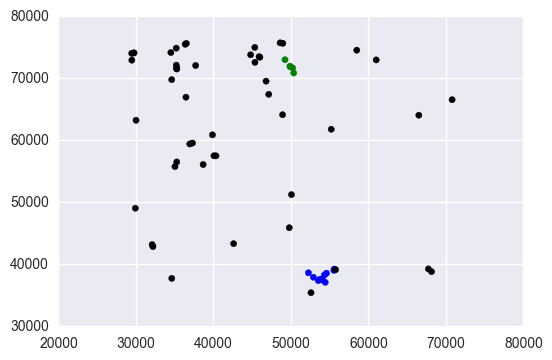

In [95]:
%matplotlib inline
visualize_projection(sequences, length_array)

In [34]:
long_sequences = sequences[length_array > 2]
print long_sequences.shape
visualize_sequences(long_sequences)

(66, 11, 8)
len(slopes): 219


In [26]:
#cleared_data.to_csv("cleared_data_500000")

# CRF algorthim on sequences

In [50]:
def prepare_training_set(sequences, length_array):
    X_train = []
    y_train = []
    for i in range(len(sequences)):
        new_seq = []
        seq = sequences[i][:length_array[i]]
        for index in range(len(seq) - 1):
            features = compute_features(np.array([seq[index]]), np.array([seq[index + 1]])).reshape(6)
            new_seq.append(features)
        X_train.append(np.array(new_seq))
        y_train.append(np.array([seq[0][5]] * (length_array[i] - 1), dtype = int))
    
    return np.array(X_train), np.array(y_train)

In [51]:
X_train, y_train = prepare_training_set(long_sequences, length_array[length_array > 2])

In [52]:
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

In [77]:
model = ChainCRF()
ssvm = FrankWolfeSSVM(model=model, C=50, max_iter=20)
ssvm.fit(X_train, y_train) 

pred = ssvm.predict(X_train) 